# **Modelos de Machine Learning**

A lo largo de este notebook, se pusieron en prueba tres modelos de Machine Learning: K-Vecinos, Árbol de decisión y Máquina de Vectores de Soporte, utilizando diferentes variables para el entrenamiento; y a partir de los resultados obtenidos, se logró determinar cuales variables terminan en hospitalización. 


## **Carga de Datos y Librerías**

Los datos utilizados corresponden al archivo Encoded_dataset.csv, el cual contiene las variables ya codificadas y optimizadas para el entrenamiento de los modelos. 

El archivo Encoded_dataset.csv fue el resultado del análisis exploratorio y de la transformación de datos que se le hizo a los datos originales en el notebook "EDA_ETL.ipynb" en el repositorio del proyecto.

In [3]:
# Para Manejo y Visualización de Datos
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Metodologías de Oversampling
from imblearn.over_sampling import RandomOverSampler

# Para Selección de Variables
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

# Para el Modelado y Modelos de Machine Learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Métricas de Evaluación
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

df = pd.read_csv('./EDA_ETL_Results/Encoded_dataset.csv', index_col=[0])
df.head(5)

,Edad,Diabetes,Hospitalizacion_ultimo_mes,Psa,Biopsias_previas,Volumen_prostatico,Antibiotico_en_profilaxis,N_Muestras,Cup,EPOC,Biopsia,Complicacion_infecciosa,Fiebre,Itu,Cultivo,Agente_aislado,Patron_de_resistencia,Hospitalizacion
0,53.0,0,0,4.0,0,1,1,12.0,0,0,7,1,1,0,0,0,0,1
1,56.0,0,0,7.7,0,1,1,12.0,0,0,7,1,1,0,0,0,0,1
2,57.0,0,0,29.0,1,1,1,24.0,0,0,7,1,1,0,1,1,1,1
3,56.0,0,0,7.0,0,1,1,12.0,0,0,7,1,1,0,0,0,0,1
4,55.0,0,0,29.0,1,1,1,24.0,0,0,7,1,1,0,1,1,0,1


Se tiparon nuevamente las variables categóricas que fueron interpretadas como valores enteros.

In [87]:
columns = df.select_dtypes(include=['int64']).columns
df[columns] = df[columns].astype('category')

## **Balance del Dataset**

Como paso previo a la creación de los modelos, se revisó el balance de la variable objetivo: "Hospitalizacion".

El siguiente gráfico Scatter muestra una distribución de las categorías de la variable objetivo. El uso de las columnas "Edad" y "Psu" fue solo para generar la distribución del gráfico, y no representan nada respecto al balance de "Hospitalizacion".

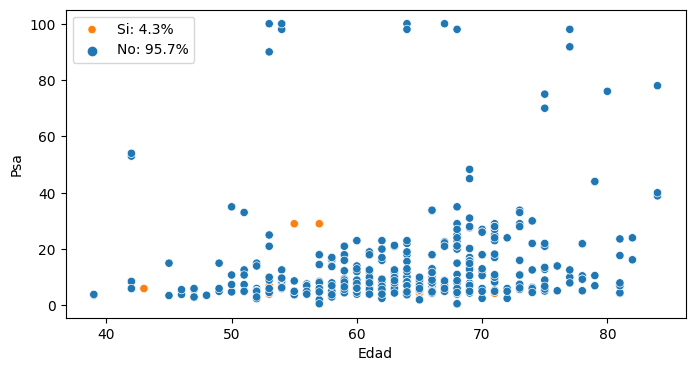

In [88]:
y = df['Hospitalizacion'].values
data_plot = pd.DataFrame({'Edad': df["Edad"].values, 'Psa': df["Psa"].values, 'target': y})

dist_target = df['Hospitalizacion'].value_counts(normalize = True)
si_dist = str(round(dist_target[0] * 100, 1)) + "%"
no_dist = str(round(dist_target[1] * 100, 1)) + "%"

plt.figure(figsize=(8, 4))
ax = sns.scatterplot(x='Edad', y='Psa', hue='target', data=data_plot)
ax.legend(labels=["Si: " + no_dist,"No: " + si_dist])

El dataset se encuentra desbalanceado para la variable objetivo y son muy pocos los registros que se tienen, por lo que se realizará oversampling para aumentar la cantidad de muestras con la categoría minoritaria.

## **Selección de Variables**

Para entrenar los modelos, se hizo una rigurosa selección de características que pudieran categorizar a un paciente como hospitalizado o no hospitalizdo, utilizando metodologías que van de acuerdo al tipo de dato entrada (Input) y el tipo de dato de salida (Output).

In [89]:
df.dtypes

Edad                           float64
Diabetes                      category
Hospitalizacion_ultimo_mes    category
Psa                            float64
Biopsias_previas              category
Volumen_prostatico            category
Antibiotico_en_profilaxis     category
N_Muestras                     float64
Cup                           category
EPOC                          category
Biopsia                       category
Complicacion_infecciosa       category
Fiebre                        category
Itu                           category
Cultivo                       category
Agente_aislado                category
Patron_de_resistencia         category
Hospitalizacion               category
dtype: object

Del total de 20 variables: 5 fueron predictoras numéricas, 14 fueron predictoras categóricas y 1 fue objetivo categórica. Considerarndo los tipos de datos predictores y el tipo de dato objetivo, se selecionaron las siguientes metodologías:

- Correlación de Kendalls: input numérico -> output categórico.
- Chi-Cuadrado: input categórico -> output categórico.

### **Correlación De Kendalls**

Este método de selección se utilizó para medir la correlación lineal de las variables numéricas con la variable objetivo: Hospitalización.

<Axes: >

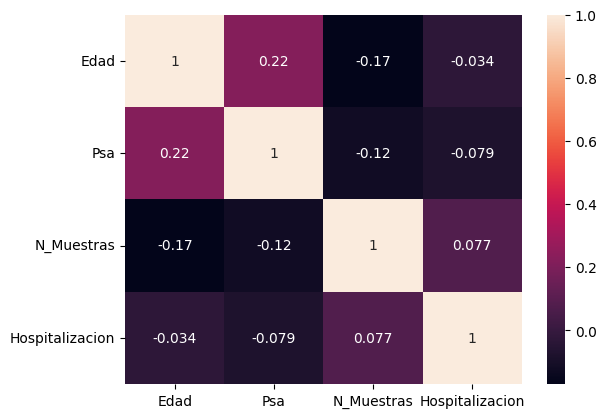

In [90]:
df_corr = df.copy()
df_corr['Hospitalizacion'] = df_corr['Hospitalizacion'].astype('int')
cor = df_corr.corr(method='kendall', numeric_only=True)
sns.heatmap(cor, annot = True)

Como se muestra en el gráfico, ninguna de las variables numéricas del dataset mostraron correlacionarse fuertemente con la variable objetivo. Por lo tanto, el poder de clasificación de estas fue muy poco.

### **Chi-Cuadrado**

Este método de selección se uso para las variables categóricas, y para implementarlo, se hizo uso de la librería sklearn.

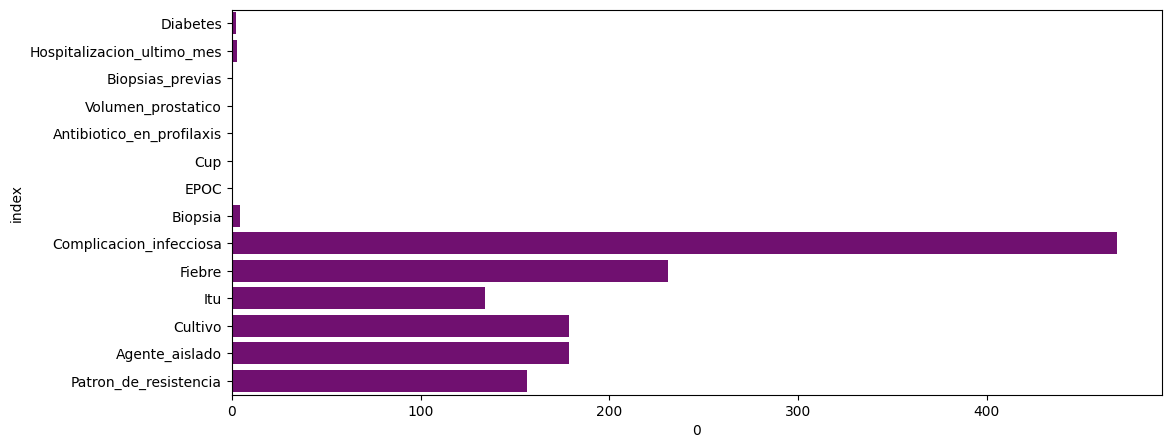

In [91]:
X = df.select_dtypes(include=['category']).drop('Hospitalizacion', axis=1)
y = df['Hospitalizacion'].values.astype('float')

select = SelectKBest(score_func=chi2, k=6)
fit = select.fit(X, y)

X_new = select.fit_transform(X, y)

s = pd.Series(data=fit.scores_,index=X.columns).reset_index()
plt.figure(figsize= (12,5))
sns.barplot(data=s, y='index', x=0, orient='h', color="purple")
filter = select.get_support()
features = np.array(X.columns)

De acuerdo a los resultados de CHI-Cuadrado, las variables categóricas relacionadas a la presencia de complicaciones infecciosas son las que determinan si un paciente termina o no en hospitalización. El resto de variabes no mostraron tener ninguna correalacióon con la variable objetivo.

En este sentido, se tomaron cuatro caracteristicas para entrenar el modelo: Complicacion_infecciosa, Fiebre, Cultivo y Agente_aislado. Siendo Complicacion_infecciosa la variable mas relevante para clasificar hospitalizacion.

## **Modelos de Clasificación**

Como se pudo apreciar en los resultados de CHI-Cuadrado, las complicaciones infecciosas tienen un alto poder de clasificación, indicando que estas características tienden a terminar en hospitalizacion. Por lo tanto, se entrenó un primer modelo en el que se esperaron resultados bastante favorables.

Por otro lado, también se decidió evaluar el resto de variables que no estuvieran relacionadas con complicaciones infecciosas incluso aunque no tuvieran buena correlación con la variable objetivo. Esto con el fin de medir el poder de clasificación del resto de variable: tanto categóricas como numéricas.

## **Modelo: Complicaciones Infecciosas**

Para este primer modelo, se usaron las variables relacionadas con la aparición de complicaciones infecciosas por tener altos resultados en CHI-Cuadrado. El objetivo de este modelo,fue corroborar si estos padecimientos terminan o no en complicaciones infecciosas.

Como desde un inicio se esperaron buenos resultados, se escogió el modelo de K-vecinos de forma arbitraria.

Además, se hizo un oversampling de la categoría minotaría, dejando misma cantidad de paciente hospitalizados como no hospitalizado. También se hizo un ajuste de hiperparámetros con el fin de obtener los mejores resultados.

In [92]:
X = df[features[filter]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

ros = RandomOverSampler(random_state=42)
X_test_ros, y_test_ros = ros.fit_resample(X_test, y_test)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

clf = KNeighborsClassifier()
param_grid_clf = {
  'n_neighbors':np.arange(1, 20),
  'weights': ['uniform', 'distance'],
  'leaf_size':[1,3,5,7,10],
  'algorithm':['auto', 'kd_tree']
}

model_clf = GridSearchCV(clf, param_grid=param_grid_clf, cv=5)
model_clf.fit(X_train_ros,y_train_ros)

print("Mejores hiperparámetros: "+str(model_clf.best_params_))
print("Mejor Score: "+str(model_clf.best_score_)+'\n')

Mejores hiperparámetros: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 3, 'weights': 'uniform'}
Mejor Score: 0.9985401459854014



### **Reporte de Clasificación**

In [93]:
y_pred = model_clf.predict(X_test_ros)
report = classification_report(y_test_ros, y_pred)
print("Reporte de Clasificación: \n")
print(report)

Reporte de Clasificación: 

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       170
         1.0       0.99      1.00      1.00       170

    accuracy                           1.00       340
   macro avg       1.00      1.00      1.00       340
weighted avg       1.00      1.00      1.00       340



Como se pudo ver en el reporte, este modelo clasificó correctamente a los pacientes no hospitalizados y si hospitalizados teniendo una exactitud del 99%. Y de acuerdo a las variables con las que se entrenó, se pudo concluir que la presencia de complicaciones infecciosas termina en hospitalización en la mayoría de los casos.

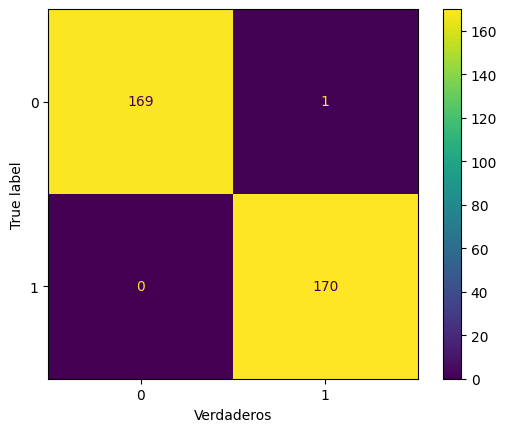

In [94]:
matrix = confusion_matrix(y_test_ros, y_pred)
cm_display = ConfusionMatrixDisplay(matrix)

cm_display.plot()
plt.xlabel('Predicciones')
plt.xlabel('Verdaderos')
plt.show()

### **Modelos: Antecedentes y Morbilidad del Paciente**

El objetivo de estos modelo es clasificar si un paciente será o no hospitalizado incluso antes de la aparición de complicaciones infecciosa, lo que es un factor significativo a la hora de hospitalizar a un paciente de acuerdo al modelo anterior creado.

Se usaron los modelos: K-vecinos, arbol de dicisión y Máquina de Vectores de soporte; y para estos tres modelos se usaron las siguientes variables:

- **Numéricas:** Psa.
- **Categóricas:** Resultados de la Biopsia, Hospitalización útlimo mes y Diabetes.

Todas estas variables corresponden a los antecedentes y morbilidad del Paciente, y son, en estas categorías, las más correlacionadas con la hospitalización de un paciente.

Por úlitmo, como ha había encontrado previamente un desbalance de la variable objetivo, se hizo un proceso de OverSampling aumentando la cantidad de muestras de la categoría minoritaria (si hospitalizados).


In [95]:
ros = RandomOverSampler(random_state=42)
X = df[['Biopsia', 'Hospitalizacion_ultimo_mes', 'Diabetes', 'Psa']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)

Al igual que en el caso anterior, por cada modelo se realizó una optimización de hiperparámetros para obtener el mejor resultado posible.

### **K-Vecinos más Cercanos**

In [96]:
clf = KNeighborsClassifier()
param_grid_clf = {
  'n_neighbors':np.arange(1, 20),
  'weights': ['uniform', 'distance'],
  'leaf_size':[1,3,5,7,10],
  'algorithm':['auto', 'kd_tree']
}

model_clf = GridSearchCV(clf, param_grid=param_grid_clf, cv=5)
model_clf.fit(X_train_ros, y_train_ros)

print("Mejores hiperparámetros: "+str(model_clf.best_params_))
print("Mejor Score: "+str(model_clf.best_score_)+'\n')

Mejores hiperparámetros: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 19, 'weights': 'distance'}
Mejor Score: 0.8910081455622553



### **Árbol de Decisión**

In [97]:
tree = DecisionTreeClassifier()
param_grid_tree = {
  "criterion":['gini', 'entropy'],
  "max_depth": range(1, 10),
  "min_samples_split": range(2, 10),
  "min_samples_leaf": range(1, 5)
}

model_tree = GridSearchCV(tree, param_grid=param_grid_tree, cv=5)
model_tree.fit(X_train_ros, y_train_ros)

print("Mejores hiperparámetros: "+str(model_tree.best_params_))
print("Mejor Score: "+str(model_tree.best_score_)+'\n')

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor Score: 0.9302232095631016



## **Máquina de Vectores de Soporte**

In [98]:
svc = SVC(probability=True)
param_grid_SVC = {
  'C': [0.1, 1, 10, 100, 1000],
  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
  'kernel': ['rbf']
}

model_svc = GridSearchCV(svc, param_grid=param_grid_SVC, cv=5)
model_svc.fit(X_train_ros, y_train_ros)

print("Mejores hiperparámetros: "+str(model_svc.best_params_))
print("Mejor Score: "+str(model_svc.best_score_)+'\n')

Mejores hiperparámetros: {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
Mejor Score: 0.9360097323600973



### **Métricas de Evaluación**

El mejor modelo fue Máquina de Vectores de Soporte con un score de 93.6%, por lo que se prosiguió a revisar las métricas de evaluación de este modelo para examinar como se comportó.

In [99]:
X_test_ros, y_test_ros = ros.fit_resample(X_test, y_test)
y_pred = model_svc.predict(X_test_ros)

#### **Reporte de Clasificación**

In [100]:
report = classification_report(y_test_ros , y_pred)
print("Reporte de Clasificación: \n")
print(report)

Reporte de Clasificación: 

              precision    recall  f1-score   support

         0.0       0.64      0.88      0.74       170
         1.0       0.81      0.51      0.62       170

    accuracy                           0.69       340
   macro avg       0.73      0.69      0.68       340
weighted avg       0.73      0.69      0.68       340



Mediante este reporte, se pudo verificar como el modelo logró predecir correctamente el 88% de la categoría 0 (No Hospitalizados) y un 51% de la categoria 1 (si hospitalizados). Por otro lado, el modelo logró una exactitud del 70%, lo que indica que el modelo es fiable un 70% de las veces.

#### **Matriz De Confusión**

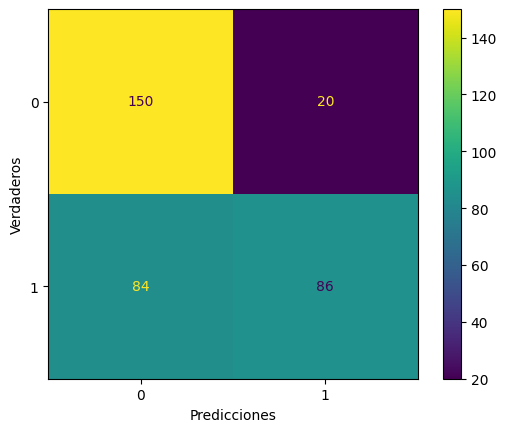

In [101]:
matrix = confusion_matrix(y_test_ros, y_pred)
cm_display = ConfusionMatrixDisplay(matrix)

cm_display.plot()
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.show()

Este modelo para la categoría 0 logró clasificar correctamente 150 muestras de 170, siendo confiable para paciente que no terminaron en hospitalizacion. Sin embargo, para los pacientes que si terminaron en hospitalización solo logró predecir correctamente la mitad de los casos, por lo tanto, se puede concluir que los estos factores difícilmente pueden predecir si un paciente será o no hospitalizado, y es necesario primero evaluar la presencia de Complicaciones Infecciosas.

## Conclusión 

Tras la evaluación de los modelos, las categorías relacionadas con la aparición de complicaciones infecciosas son determinantes a la hora de que un paciente termine o no hospitalizado, lo que no ocurre con las variables relacionadas con la morbilidad y los antecedentes de la toma de biopsia del paciente.

El modelo entrenado con las variables relacionadas con complicaciones infecciosas logró ser casi 99% fiable, mientras que el modelo que usaba la morbilidad y los antecedentes de la toma de biopsia solo logró clasificar la mitad de los casos cuando los pacientes si terminan en hospitalización, por lo que no fue confiable.